In [1]:
from intake import open_catalog
import cf_xarray
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
list(cat)

['CESM_POP_hires_control', 'CESM_POP_hires_RCP8_5']

In [2]:
ds = cat['CESM_POP_hires_RCP8_5'].to_dask()
#slicing the data by secting aprox.the tropical north atlantic
#lats = [1200,1550]
#lons = [80,1400]
#ds = ds.isel(nlon=slice(*lons),nlat=slice(*lats))

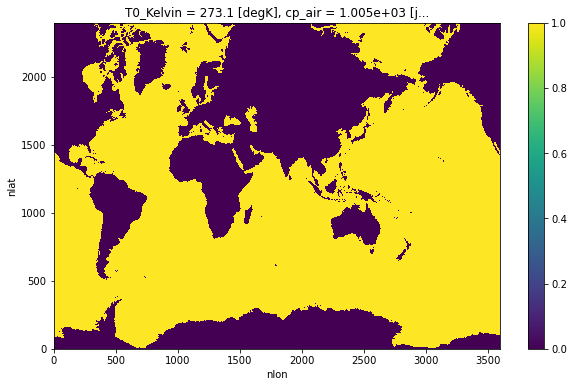

In [3]:
# create fields needed to apply the filter: wet mask and area
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

area = ds.TAREA / 10000  # convert units from cm2 to m2

In [4]:
wet_mask = wet_mask.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk
area = area.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk

ssh = ds.SSH_2.where(wet_mask)
ssh = ssh.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})  # 1 chunk

In [5]:
#filter specifications
specs = {
    'filter_scale': 60,
    'dx_min': 1,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'grid_type': gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED
}

In [6]:
#create the filter
filter_cpu = gcm_filters.Filter(grid_vars={'area': area, 'wet_mask': wet_mask}, **specs)
filter_cpu

Filter(filter_scale=60, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=66, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>)

In [7]:
#Apply the filter
filtered_cpu = filter_cpu.apply(ssh, dims=['nlat', 'nlon'])
filtered_cpu

<xarray.DataArray (time: 16401, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(16401, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
  * time                (time) object 2006-01-02 00:00:00 ... 2051-01-01 00:0...
    vonkar              float64 0.4
Dimensions without coordinates: nlat, nlon

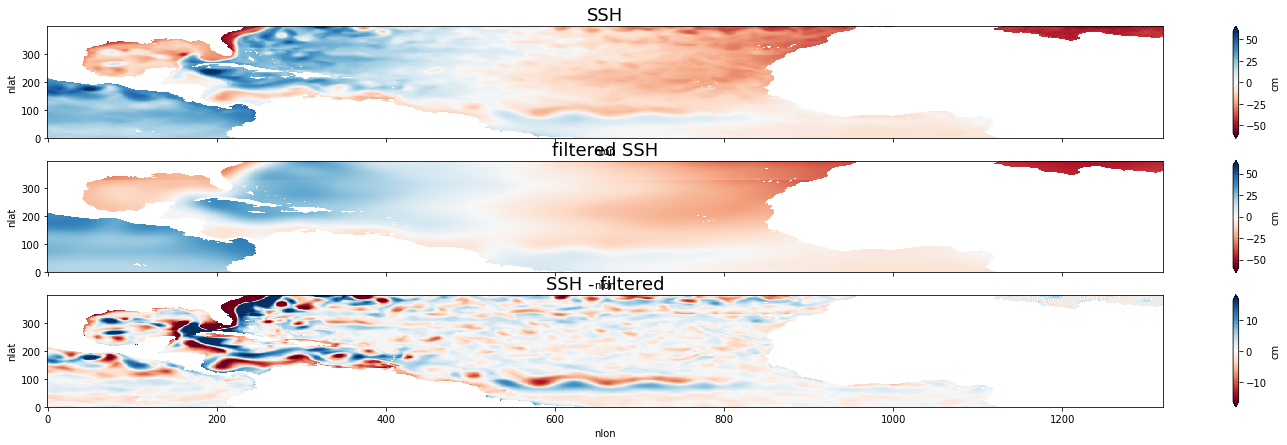

In [8]:
#plotting
lats = [1150,1550]
lons = [80,1400]

fig,axs = plt.subplots(3,1,figsize=(25,7),sharex=True)
ssh = ssh.isel(nlon=slice(*lons),nlat=slice(*lats),time=20)
m = ssh.mean().values
s = ssh.std().values
ssh = ssh - m

ssh.plot.pcolormesh(
    ax=axs[0],
    vmin=-3*s, vmax=3*s, cmap='RdBu',
    cbar_kwargs={'label': 'cm'},
    extend = 'both'
)

axs[0].set_title('SSH', fontsize=18)

filtered_cpu = filtered_cpu.isel(nlon=slice(*lons),nlat=slice(*lats),time=20)
filtered_cpu = filtered_cpu - m

filtered_cpu.plot.pcolormesh(
    ax=axs[1], 
    vmin=-3*s, vmax=3*s, cmap='RdBu',
    cbar_kwargs={'label': 'cm'},
    extend = 'both'
)

axs[1].set_title('filtered SSH', fontsize=18);

diff = ssh - filtered_cpu

diff.plot.pcolormesh(
    ax=axs[2], 
    vmin=-3*diff.std().values, vmax=3*diff.std().values, cmap='RdBu',
    cbar_kwargs={'label': 'cm'},
    extend = 'both'
)

axs[2].set_title('SSH - filtered', fontsize=18);

plt.savefig("filtered_SSH_test_60km.png")

In [37]:
m = ssh.mean().values

In [38]:
m

array(-4.859357e-07, dtype=float32)

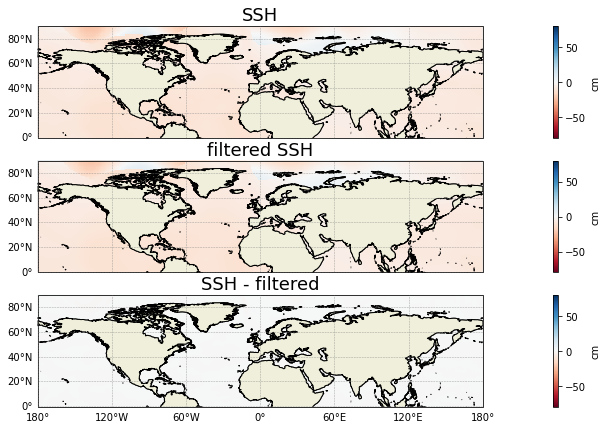

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from matplotlib import rc
from matplotlib import gridspec

#plotting
vmin = -80
vmax = 80
lats = [1150,1550]
lons = [80,1400]

#rc('font', family={'family': 'serif', 'serif': ['Times'],'size': 12})
#rc('text', usetex=True)

#Cartopy Proprieties
pro = ccrs.PlateCarree()
geo = ccrs.PlateCarree() 
land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', 
            land_resolution, edgecolor='k', facecolor=cfeature.COLORS['land'])

fig,axs = plt.subplots(3,1,figsize=(25,7),sharex=True, 
                       subplot_kw={'projection': pro})
ssh.isel(nlon=slice(*lons),nlat=slice(*lats),time=20).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, cmap='RdBu',
    cbar_kwargs={'label': 'cm'}
)
axs[0].coastlines(resolution=land_resolution, color='black', linewidth=1)
axs[0].add_feature(land_poly)
axs[0].set_title('SSH', fontsize=18)

#Grid and axis
#axs[0].set_extent([250., 10., 0., 45.])
g = axs[0].gridlines(crs=pro, draw_labels=True, linewidth=0.5, zorder=100,
                     color='gray', alpha=0.7, linestyle='--')
g.top_labels= False
g.right_labels = False
g.bottom_labels=False

filtered_cpu.isel(nlon=slice(*lons),nlat=slice(*lats),time=20).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, cmap='RdBu',
    cbar_kwargs={'label': 'cm'}
)
axs[1].coastlines(resolution=land_resolution, color='black', linewidth=1)
axs[1].add_feature(land_poly)
axs[1].set_title('filtered SSH', fontsize=18);

#Grid and axis
#axs[1].set_extent([250., 10., 0., 45.])
g = axs[1].gridlines(crs=pro, draw_labels=True, linewidth=0.5, zorder=100,
                     color='gray', alpha=0.7, linestyle='--')
g.top_labels= False
g.right_labels = False
g.bottom_labels=False

diff = ssh.isel(nlon=slice(*lons),nlat=slice(*lats),
                time=20) - filtered_cpu.isel(nlon=slice(*lons),
                                             nlat=slice(*lats),time=20)
diff.plot(
    ax=axs[2], 
    vmin=vmin, vmax=vmax, cmap='RdBu',
    cbar_kwargs={'label': 'cm'}
)

axs[2].coastlines(resolution=land_resolution, color='black', linewidth=1)
axs[2].add_feature(land_poly)
axs[2].set_title('SSH - filtered', fontsize=18);

#Grid and axis
#axs[2].set_extent([250., 10., 0., 45.])
g = axs[2].gridlines(crs=pro, draw_labels=True, linewidth=0.5, zorder=100,
                     color='gray', alpha=0.7, linestyle='--')
g.top_labels= False
g.right_labels = False


plt.savefig("filtered_SSH_test_cartopy.png")

array(79.59312615)